In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [42]:
using DataFrames, DataFramesMeta, GLM
using CairoMakie, ColorSchemes, LsqFit
using Statistics, SpecialFunctions, StatsBase
using Random, Distributions
using LaTeXStrings
using LinearAlgebra
using FHist

In [70]:
include("./Data_Input.jl")
using .DataImport

include("./Distributions.jl")
using .PlotDistributions

include("./models.jl")
using .GenerativeModels

# Slide 1

In [ ]:
# sep_data = DataImport.GetLongData("./Data/longitudinal.RData"; min_samples=1, min_counts=1, min_nreads=1e3);

# data = sep_data["M3"]["ORALCAVITY"]

# data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

# otus = unique(data.otu_id)
# max_day = maximum(data.experiment_day) + 1
# otu_groups = groupby(data, :otu_id)

# y = zeros(max_day, length(otus))
# env_data = []
# otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

# for g in otu_groups
#     otu = g.otu_id[1]
#     i = otu_index[otu]
#     for (t, fval) in zip(g.experiment_day, g.f)
#         if 1 <= t+1 <= max_day
#             y[t+1, i] = fval
#         end
#     end

#     y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
#     push!(env_data, y[:,i])
# end

# matrix_data = hcat(env_data...)

# # Create the figure and axis
# fig = Figure(size = (800, 300), fontsize = 20)
# ax = Axis(fig[1, 1], xlabel = "day", ylabel = "abundance", limits = (130, 135, 0, 0.003))

# # Color palette
# colors = Makie.wong_colors()
# range = 130:135

# # Separate vectors for legend handles and labels
# legend_handles = []
# legend_labels = []

# # Plot each OTU's data
# for (i, otu_idx) in enumerate([9, 4, 6])
#     lineplot = lines!(ax, range, matrix_data[range, otu_idx], color = colors[i+1])
#     scatter!(ax, range, matrix_data[range, otu_idx], color = colors[i+1], markersize = 12)
#     push!(legend_handles, lineplot)
#     push!(legend_labels, "OTU $i")
# end

# # Create the legend to the right of the axis
# Legend(fig[1, 2], legend_handles, legend_labels)

# display(fig)
# save("./Images/ts_emp_2.png", fig, px_per_unit = 2)

# Slide 2

### Cross-section

In [ ]:
# sep_data = DataImport.GetCrossSecData("./Data/crosssecdata.RData"; min_samples=3e1, min_counts=1, min_nreads=1e4);

# envs = []

# # AFD setup
# fig_afd = Figure(size = (500, 400), fontsize = 20)
# ax_afd = Axis(fig_afd[1, 1], xlabel="log(abundance)", ylabel="pdf",
#               yscale=log10, limits=((-4, 3), (1e-6, 1e0)), title="AFD")

# betas = []
# means = []
# stds = []
# hmeans = []
# hstds = []
# scatters_afd = []

# # Taylor setup
# fig_taylor = Figure(size = (500, 400), fontsize = 20)
# ax_taylor = Axis(fig_taylor[1, 1], xlabel="log(μ)", ylabel="log(σ)", title="Taylor's Law")

# centers_taylor = []
# values_taylor = []
# scatters_taylor = []

# # MAD setup
# fig_mad = Figure(size = (500, 400), fontsize = 20)
# ax_mad = Axis(fig_mad[1, 1], xlabel="log(μ)", ylabel="pdf",
#               yscale=log10, limits=((-3, 3), (5e-6, 5e0)), title="MAD")

# scatters_mad = []
# cutoffs = Dict("SLUDGE" => -18.8,
#     "LAKE" => -17.0,
#     "RIVER" => -17.5,
#     "GUT" => -14.3, #-17.5
#     "GLACIER" => -16.25,
#     "SEAWATER" => -17.9,
#     "SOIL" => -14.25,
#     "ORAL" => -16.1,
#     "VAGINAL" => -Inf,
#     "FECES" => -Inf,
#     "AQUA1" => -Inf,
#     "AQUA2" => -Inf,
#     "ORALCAVITY" => -Inf,
#     "SKIN" => -Inf
#     )

# c=0
# for (key, data) in sep_data
#     c += 1
#     data.f = data.count ./ data.nreads
#     otus = unique(data.otu_id)
#     runs = unique(data.run_id)
#     if length(otus) < 10
#         continue
#     end

#     y = zeros(length(runs), length(otus))
#     env_data = []
#     otu_index = Dict(otu => i for (i, otu) in enumerate(otus))
#     run_index = Dict(run => i for (i, run) in enumerate(runs))

#     for g in groupby(data, :otu_id)
#         i = otu_index[g.otu_id[1]]
#         for (run, fval) in zip(g.run_id, g.f)
#             y[run_index[run], i] = fval
#         end
#         y[:, i] .*= (count(!iszero, y[:, i]) / length(y[:, i]))
#         push!(env_data, y[:, i])
#     end

#     matrix_data = hcat(env_data...)

#     # Plot AFD
#     afd = PlotDistributions.make_AFD(matrix_data; missing_thresh=size(matrix_data, 1), Δb=0.2, env=key)
#     scatterplot = scatter!(ax_afd, afd["hist"][1], afd["hist"][2],
#                             markersize=12,
#                             strokewidth = 0.5,
#                             strokecolor = :black
#                             )

#     push!(betas, afd["params"]["β"])
#     push!(means, afd["params"]["μ_x"])
#     push!(stds, afd["params"]["σ_x"])
#     push!(hmeans, afd["hparams"]["μ"])
#     push!(hstds, afd["hparams"]["σ"])
#     push!(envs, afd["env"])
#     push!(scatters_afd, scatterplot)

#     # Plot Taylor
#     taylor = PlotDistributions.make_Taylor(matrix_data; missing_thresh=size(matrix_data, 1), Δb=0.2, env=key)
#     scatterplot = scatter!(ax_taylor, taylor["hist"][1], taylor["hist"][2],
#                             markersize=12,
#                             strokewidth = 0.5,
#                             strokecolor = :black
#                             )

#     push!(centers_taylor, taylor["hist"][1])
#     push!(values_taylor, taylor["hist"][2])
#     push!(scatters_taylor, scatterplot)

#     # Plot MAD
#     mad = PlotDistributions.make_MAD(matrix_data; missing_thresh=size(matrix_data, 1), Δb=0.2, env=key, c=exp(cutoffs[key]))
#     scatterplot = scatter!(ax_mad, mad["hist"][1], mad["hist"][2],
#                             markersize=12,
#                             strokewidth = 0.5,
#                             strokecolor = :black
#                             )

#     push!(scatters_mad, scatterplot)
# end

# # === AFD ===
# xarr = -6.0:0.05:2
# β = mean(betas)
# μ_x = mean(means)
# σ_x = mean(stds)
# μ = mean(hmeans)
# σ = mean(hstds)

# g_gamma = [10^(β * x - μ_x / σ_x^2 * exp(x) - loggamma(β) + β * log(μ_x / σ_x^2)) for x in (xarr .* sqrt(2 * σ^2) .+ μ)]
# lineplot = lines!(ax_afd, xarr, g_gamma, color=:black, linewidth=1.5)

# legend = Legend(fig_afd, vcat(lineplot, scatters_afd),
#     vcat(["Gamma(β = $(round(β, digits = 2)))"], envs);
#     tellwidth = false,
#     patchsize = (8, 8),
#     labelsize = 12,
#     framevisible = false)

# translate!(legend.blockscene, 110, 220)
# display(fig_afd)

# # === TAYLOR ===
# func(x, p) = p[1] .* x .+ p[2]
# p0 = [2.0, 0.0]  # Initial guess for the parameters
# fit = curve_fit(func, vcat(centers_taylor...), vcat(values_taylor...), p0)
# p_fit = fit.param

# bmin, bmax = extrema(vcat(centers_taylor...))
# xarr = bmin:0.01:bmax
# fitted_y = func(xarr, p_fit)
# lineplot = lines!(ax_taylor, xarr, fitted_y, color=:black, linewidth=1.5)

# legend = Legend(fig_taylor, vcat(lineplot, scatters_taylor),
#     vcat(["y = $(round(p_fit[1], digits=2))x + $(round(p_fit[2], digits=2))"], envs);
#     tellwidth = false,
#     patchsize = (8, 8),
#     labelsize = 12,
#     framevisible = false)

# translate!(legend.blockscene, 110, 220)
# display(fig_taylor)

# # === MAD ===
# xarr = -3.0:0.05:3
# lognorm = [10^(-x^2) for x in xarr]
# lineplot = lines!(ax_mad, xarr, lognorm, color=:black, linewidth=1.5)
# x_cutoff = -0.3
# vlines!(ax_mad, [x_cutoff]; color=:black, linestyle=:dash, linewidth=1.5)
#         text!(ax_mad, "cutoff";
#             position = (x_cutoff - 0.3, 1e-5),
#             rotation = π/2,
#             align = (:left, :center),
#             color = :black,
#             fontsize = 16)

# legend = Legend(fig_mad, vcat(lineplot, scatters_mad),
#     vcat(["Lognormal"], envs);
#     tellwidth = false,
#     patchsize = (8, 8),
#     labelsize = 12,
#     framevisible = false)

# translate!(legend.blockscene, 110, 220)
# display(fig_mad)

# # === Save plots ===
# save("./Images/cross_AFD.png", fig_afd; px_per_unit=2)
# save("./Images/cross_Taylor.png", fig_taylor; px_per_unit=2)
# save("./Images/cross_MAD.png", fig_mad; px_per_unit=2)


### Longitudinal

In [ ]:
# sep_data = DataImport.GetLongData("./Data/longitudinal.RData"; min_samples=1, min_counts=1, min_nreads=1e3);

# envs = []

# # AFD setup
# fig_afd = Figure(size = (500, 400), fontsize = 20)
# ax_afd = Axis(fig_afd[1, 1], xlabel="log(abundance)", ylabel="pdf",
#               yscale=log10, limits=((-4, 3), (1e-6, 1e0)), title="AFD")

# betas = []
# means = []
# stds = []
# hmeans = []
# hstds = []
# scatters_afd = []

# # Taylor setup
# fig_taylor = Figure(size = (500, 400), fontsize = 20)
# ax_taylor = Axis(fig_taylor[1, 1], xlabel="log(μ)", ylabel="log(σ)", title="Taylor's Law")

# centers_taylor = []
# values_taylor = []
# scatters_taylor = []

# # MAD setup
# fig_mad = Figure(size = (500, 400), fontsize = 20)
# ax_mad = Axis(fig_mad[1, 1], xlabel="log(μ)", ylabel="pdf",
#               yscale=log10, limits=((-3, 3), (5e-6, 5e0)), title="MAD")

# scatters_mad = []
# cutoffs = Dict("M3" => Dict("FECES" => -15.1, "ORALCAVITY" => -15.2, "L_PALM" => -14.4, "R_PALM" => -15.5),
#               "F4" => Dict("FECES" => -13.8, "ORALCAVITY" => -12.8, "L_PALM" => -13.6, "R_PALM" => -12.3)
#              )

# for (key, sub_data) in sep_data
#     for (subkey, data) in sub_data

#         data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

#         otus = unique(data.otu_id)
#         max_day = maximum(data.experiment_day) + 1
#         otu_groups = groupby(data, :otu_id)

#         y = zeros(max_day, length(otus))
#         env_data = []
#         otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

#         for g in otu_groups
#             otu = g.otu_id[1]
#             i = otu_index[otu]
#             for (t, fval) in zip(g.experiment_day, g.f)
#                 if 1 <= t+1 <= max_day
#                     y[t+1, i] = fval
#                 end
#             end

#             y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
#             push!(env_data, y[:,i])
#         end

#         matrix_data = hcat(env_data...)

#         # Plot AFD
#         afd = PlotDistributions.make_AFD(matrix_data; missing_thresh=size(matrix_data, 1), Δb=0.2, env="$(key[1]) $subkey")
#         scatterplot = scatter!(ax_afd, afd["hist"][1], afd["hist"][2],
#                                 markersize=12,
#                                 strokewidth = 0.5,
#                                 strokecolor = :black
#                                 )
    
#         push!(betas, afd["params"]["β"])
#         push!(means, afd["params"]["μ_x"])
#         push!(stds, afd["params"]["σ_x"])
#         push!(hmeans, afd["hparams"]["μ"])
#         push!(hstds, afd["hparams"]["σ"])
#         push!(envs, afd["env"])
#         push!(scatters_afd, scatterplot)
    
#         # Plot Taylor
#         taylor = PlotDistributions.make_Taylor(matrix_data; missing_thresh=size(matrix_data, 1), Δb=0.2, env="$(key[1]) $subkey")
#         scatterplot = scatter!(ax_taylor, taylor["hist"][1], taylor["hist"][2],
#                                 markersize=12,
#                                 strokewidth = 0.5,
#                                 strokecolor = :black
#                                 )
    
#         push!(centers_taylor, taylor["hist"][1])
#         push!(values_taylor, taylor["hist"][2])
#         push!(scatters_taylor, scatterplot)
    
#         # Plot MAD
#         mad = PlotDistributions.make_MAD(matrix_data; missing_thresh=size(matrix_data, 1), Δb=0.2, env="$(key[1]) $subkey", c=exp(cutoffs[key][subkey]))
#         scatterplot = scatter!(ax_mad, mad["hist"][1], mad["hist"][2],
#                                 markersize=12,
#                                 strokewidth = 0.5,
#                                 strokecolor = :black
#                                 )
    
#         push!(scatters_mad, scatterplot)
#     end
# end

# # === AFD ===
# xarr = -6.0:0.05:2
# β = mean(betas)
# μ_x = mean(means)
# σ_x = mean(stds)
# μ = mean(hmeans)
# σ = mean(hstds)

# g_gamma = [10^(β * x - μ_x / σ_x^2 * exp(x) - loggamma(β) + β * log(μ_x / σ_x^2)) for x in (xarr .* sqrt(2 * σ^2) .+ μ)]
# lineplot = lines!(ax_afd, xarr, g_gamma, color=:black, linewidth=1.5)

# legend = Legend(fig_afd, vcat(lineplot, scatters_afd),
#     vcat(["Gamma(β = $(round(β, digits = 2)))"], envs);
#     tellwidth = false,
#     patchsize = (8, 8),
#     labelsize = 12,
#     framevisible = false)

# translate!(legend.blockscene, 110, 220)
# display(fig_afd)

# # === TAYLOR ===
# func(x, p) = p[1] .* x .+ p[2]
# p0 = [2.0, 0.0]  # Initial guess for the parameters
# fit = curve_fit(func, vcat(centers_taylor...), vcat(values_taylor...), p0)
# p_fit = fit.param

# bmin, bmax = extrema(vcat(centers_taylor...))
# xarr = bmin:0.01:bmax
# fitted_y = func(xarr, p_fit)
# lineplot = lines!(ax_taylor, xarr, fitted_y, color=:black, linewidth=1.5)

# legend = Legend(fig_taylor, vcat(lineplot, scatters_taylor),
#     vcat(["y = $(round(p_fit[1], digits=2))x + $(round(p_fit[2], digits=2))"], envs);
#     tellwidth = false,
#     patchsize = (8, 8),
#     labelsize = 12,
#     framevisible = false)

# translate!(legend.blockscene, 110, 220)
# display(fig_taylor)

# # === MAD ===
# xarr = -3.0:0.05:3
# lognorm = [10^(-x^2) for x in xarr]
# lineplot = lines!(ax_mad, xarr, lognorm, color=:black, linewidth=1.5)
# x_cutoff = 0.0
# vlines!(ax_mad, [x_cutoff]; color=:black, linestyle=:dash, linewidth=1.5)
#         text!(ax_mad, "cutoff";
#             position = (x_cutoff - 0.3, 1e-5),
#             rotation = π/2,
#             align = (:left, :center),
#             color = :black,
#             fontsize = 16)

# legend = Legend(fig_mad, vcat(lineplot, scatters_mad),
#     vcat(["Lognormal"], envs);
#     tellwidth = false,
#     patchsize = (8, 8),
#     labelsize = 12,
#     framevisible = false)

# translate!(legend.blockscene, 110, 220)
# display(fig_mad)

# # === Save plots ===
# save("./Images/long_AFD.png", fig_afd; px_per_unit=2)
# save("./Images/long_Taylor.png", fig_taylor; px_per_unit=2)
# save("./Images/long_MAD.png", fig_mad; px_per_unit=2)


# Slide 3

In [ ]:
# sep_data = DataImport.GetLongData("./Data/longitudinal.RData"; min_samples=1, min_counts=1, min_nreads=1e3);

# AutoCorrs = []
# PSDs = []

# for (key, sub_data) in sep_data
#     for (subkey, data) in sub_data

#         data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

#         otus = unique(data.otu_id)
#         max_day = maximum(data.experiment_day) + 1 # add 1 because experiment_day starts from 0
#         otu_groups = groupby(data, :otu_id)

#         if length(otus) < 1e1
#             println("Skipping $(key[1]) $subkey")
#             continue
#         end
#         println("$(key[1]) $subkey")

#         y = zeros(max_day, length(otus))
#         env_data = []
#         otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

#         for g in otu_groups
#             otu = g.otu_id[1]
#             i = otu_index[otu]
#             for (t, fval) in zip(g.experiment_day, g.f)
#                 if 1 <= t+1 <= max_day
#                     y[t+1, i] = fval
#                 end
#             end

#             y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
#             push!(env_data, y[:,i])
#         end

#         matrix_data = hcat(env_data...)

#         miss = Int(floor(size(matrix_data, 1) / 3))
#         max_lag = Int(floor(size(matrix_data, 1) / 10))
#         autocorr = PlotDistributions.make_lagCorr(matrix_data; env="$(key[1]) $subkey", missing_thresh = miss, max_lag = max_lag)
#         push!(AutoCorrs, autocorr)

#         psd = PlotDistributions.make_PSD(matrix_data; env="$(key[1]) $subkey", missing_thresh = miss, freq_range=(-1.5, -0.5))
#         push!(PSDs, psd)
#     end
# end

# fig = Plots.combine_autocorr_plots(AutoCorrs, nrows=2, ncols=4, savepath=",.Images.autocorrs.png")
# display(fig)

# fig = Plots.combine_PSD_plots(PSDs, nrows=2, ncols=4, savepath="./Images/PSD.png")
# display(fig)

# Slide 7

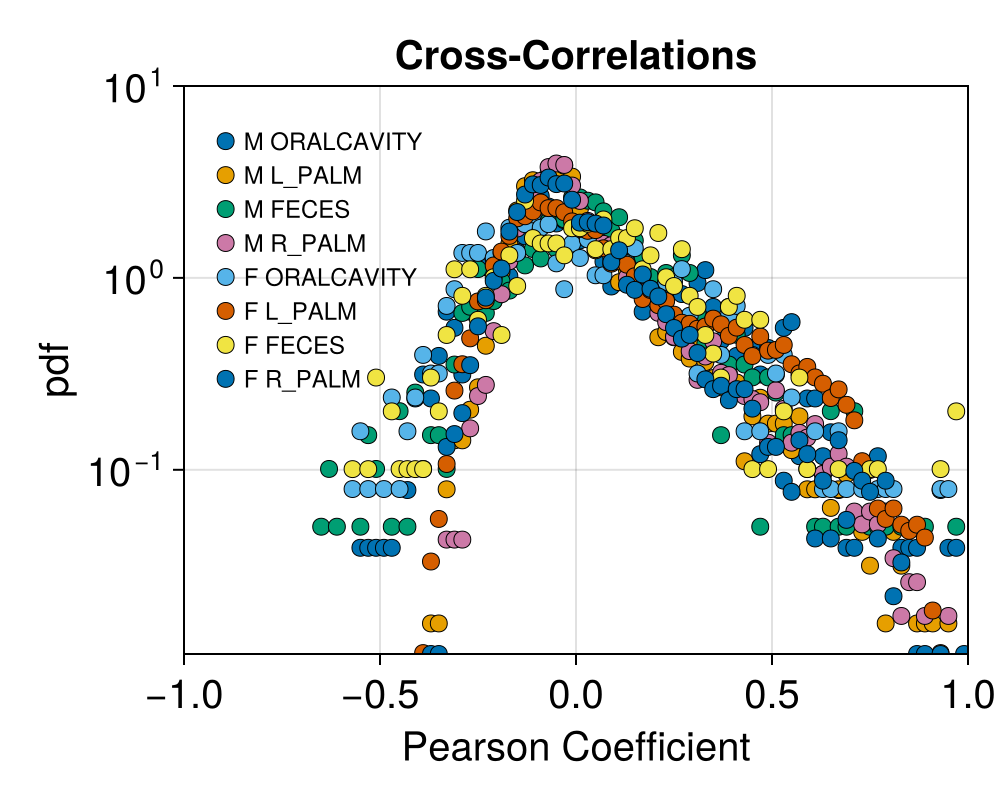

In [82]:
# sep_data = DataImport.GetLongData("./Data/longitudinal.RData"; min_samples=1, min_counts=1, min_nreads=1e3);

# envs = []

# # Setup
# fig = Figure(size = (500, 400), fontsize = 20)
# ax = Axis(fig[1, 1], xlabel="Pearson Coefficient", ylabel="pdf",
#               yscale=log10, title="Cross-Correlations")
# xlims!(ax, -1.0, 1.0)

# scatters = []

# for (key, sub_data) in sep_data
#     for (subkey, data) in sub_data

#         data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

#         otus = unique(data.otu_id)
#         max_day = maximum(data.experiment_day) + 1
#         otu_groups = groupby(data, :otu_id)

#         y = zeros(max_day, length(otus))
#         env_data = []
#         otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

#         for g in otu_groups
#             otu = g.otu_id[1]
#             i = otu_index[otu]
#             for (t, fval) in zip(g.experiment_day, g.f)
#                 if 1 <= t+1 <= max_day
#                     y[t+1, i] = fval
#                 end
#             end

#             y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
#             push!(env_data, y[:,i])
#         end

#         matrix_data = hcat(env_data...)

#         miss = Int(floor(size(matrix_data, 1) / 3))
#         crosscorr = PlotDistributions.make_lagCrossCorr(matrix_data; env="$(key[1]) $subkey", lags=[0], missing_thresh = miss)

#         corrs = crosscorr["cross_corrs"][1]
#         vals = filter(!isnan, vec([corrs[i, j] for i in 1:size(corrs, 1), j in 1:size(corrs, 2) if i > j]))  # use only lower triangle, no duplicates
#         if !isempty(vals)
#             edges = -1:0.02:1
#             fh = FHist.Hist1D(vals, binedges=edges) |> FHist.normalize
#             centers, counts = bincenters(fh), bincounts(fh)
#             scatter_plot = scatter!(ax, centers, counts; label=crosscorr["env"],
#                     markersize=12,
#                     strokewidth = 0.5,
#                     strokecolor = :black)
#             push!(scatters, scatter_plot)
#             push!(envs, crosscorr["env"])
#             ylims!(ax, minimum(counts[counts .> 0.0]), 1e1)
#         end
#     end
# end

# legend = Legend(fig, scatters,
#     envs;
#     tellwidth = false,
#     patchsize = (8, 8),
#     labelsize = 12,
#     framevisible = false)

# translate!(legend.blockscene, 110, 220)
# display(fig)

# # === Save plots ===
# save("./Images/long_CrossCorrs.png", fig; px_per_unit=2)


### Slide 5

In [15]:
# # Set global parameters
# N_species = 500
# Δt = 0.01
# n = 250000
# ϵ = 1e-9
# skip=1

# Random.seed!(1234)

# # Set conditions for temporal analysis
# K = 100 .* rand(LogNormal(), N_species)
# # Pass y0 = K to the model so it is already at staedy state

# # Solve model
# data = GenerativeModels.logistic_growth(N_species, K, Δt, n; r=1.0, K=K, σ=1.0, ε=ϵ, skip=skip)
# println("Extincted species: ", count(iszero.(data[end,:])))

In [16]:
# colors = palette(:tab10, 10)

# # Create the initial plot
# fig = plot(xlabel="time step", ylabel="abundance",
#            yrange=(0, 500), size=(600, 250), margin=5mm)

# # Loop to plot lines and scatter points
# tau = 500
# time = 1:size(data[end-5000:tau:end, :], 1)
# for i in 1:4
#     plot!(fig, time .* 100, data[end-5000:tau:end, i], label=nothing, c=colors[i])
#     scatter!(fig, time .* 100, data[end-5000:tau:end, i], label=nothing, c=colors[i])
# end

# display(fig)
# savefig("./Images/SLM_time_series_skip.png")

In [17]:
# Compute distributions
# data_skip = data[1:tau:end, :]
# max_lag = Int64(floor(size(data_skip,1) / 10))
# afd = PlotDistributions.make_AFD(data_skip; Δb=0.2, plot_fig=true, plot_title="AFD", data_label="simulation")
# taylor = PlotDistributions.make_Taylor(data_skip; Δb=0.2, plot_fig=true, plot_title="Taylor's law", data_label="simulation")
# mad = PlotDistributions.make_MAD(data_skip; Δb=0.5, plot_fig=true, plot_title="MAD", data_label="simulation")
# lagcorr = PlotDistributions.make_lagCorr(data_skip; max_lag=max_lag, make_log=true, plot_fig=true, plot_title="Auto-Correlation", data_label="simulation")
# psd = PlotDistributions.make_PSD(data_skip; Δt=Δt*tau, freq_range=(-1.6, -0.5), make_log=true, plot_fig=true, plot_title="Power Spectrum Density", data_label="simulation")

# fig = afd["fig"]
# display(fig)
# savefig(fig, "./Images/SLM_AFD_skip500.png")

# fig = taylor["fig"]
# display(fig)
# savefig(fig, "./Images/SLM_Taylor_skip500.png")

# fig = mad["fig"]
# display(fig)
# savefig("./Images/SLM_MAD_skip500.png")

# fig = lagcorr["fig"]
# display(fig)
# savefig("./Images/SLM_autocorr_skip500.png")

# fig = psd["fig"]
# display(fig)
# savefig("./Images/SLM_PSD_skip500.png")

### Slide 6

In [18]:
# # Set global parameters
# N_species = 500
# Δt = 0.01
# n = 250000
# ε = 1e-6
# skip=1

# Random.seed!(1234)

# # Set conditions for temporal analysis
# K = 1000 .* rand(LogNormal(), N_species)
# ρ = 1 / (N_species*sqrt(N_species))
# A = GenerativeModels.sparse_gaussian_matrix(K, ρ; μ=-2/N_species, σ=1/N_species)

# # Solve model
# data = GenerativeModels.lotka_volterra(N_species, K, Δt, n; r=1.0, A=Matrix(A), σ=1.0, ε=ε, skip=1)
# println("Extincted species: ", count(iszero.(data[end,:])))

In [19]:
# lags = [0]
# data1 = data[end-2000:end,:]
# data2 = data[1:10:end, :]
# data2 = data2[end-2000:end, :]
# data3 = data[1:50:end, :]
# data3 = data3[end-2000:end, :]
# data4 = data[1:100:end, :]
# data4 = data4[end-2000:end, :]
# data5 = data[1:500:end, :]

# cross1 = PlotDistributions.make_lagCrossCorr(data1; missing_thresh=500, Δb=0.05, lags=lags, make_log=true, plot_fig=false)
# cross2 = PlotDistributions.make_lagCrossCorr(data2; missing_thresh=500, Δb=0.05, lags=lags, make_log=true, plot_fig=false)
# cross3 = PlotDistributions.make_lagCrossCorr(data3; missing_thresh=500, Δb=0.05, lags=lags, make_log=true, plot_fig=false)
# cross4 = PlotDistributions.make_lagCrossCorr(data4; missing_thresh=500, Δb=0.05, lags=lags, make_log=true, plot_fig=false)
# cross5 = PlotDistributions.make_lagCrossCorr(data5; missing_thresh=125, Δb=0.05, lags=lags, make_log=true, plot_fig=false)

In [20]:
# fig = plot(xlabel="cross correlation", title="Cross-Correlation (lag=0)")
# crosses = [cross1["cross_corrs"], cross2["cross_corrs"], cross3["cross_corrs"], cross4["cross_corrs"], cross5["cross_corrs"]]
# skips = [1, 10, 50, 100, 500]
# for (i, mat) in enumerate(crosses)
#     bmin = -1
#     bmax = 1
#     hist_input = filter(!isnan, mat[1])
#     fh = FHist.Hist1D(hist_input, binedges=bmin:0.05:bmax) |> FHist.normalize
#     shadow = (length(crosses) - i + 1) / length(crosses)
#     plot!(fig, fh, label="skip = $(skips[i])", alpha=shadow)
# end

# display(fig)

### Slide 7

In [55]:
# Set global parameters
N_species = 1000
Δt = 1e-2
n = 10000
ε = 1e-20
skip=1

Random.seed!(1234)

# Set conditions for temporal analysis
K = 100 .* rand(LogNormal(), N_species)
ρs = [0.0, 0.001, 0.01, 0.1]
Y = []
for ρ in ρs
    A = GenerativeModels.sparse_gaussian_matrix(K, ρ; μ=-2 / N_species, σ=1 / N_species)
    y = GenerativeModels.lotka_volterra(N_species, K, Δt, n; r=1.0, A=Matrix(A), σ=1 / sqrt(N_species), ε=ε, skip=skip)
    push!(Y, y)
end

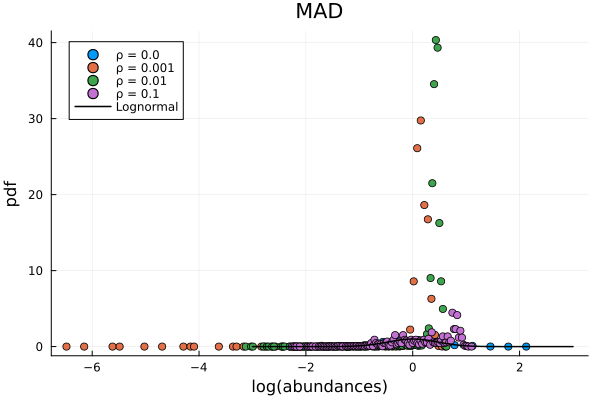

In [57]:
fig = plot(xlabel="log(abundances)", ylabel="pdf", title="MAD", legend=:topleft)

for (j, y) in enumerate(Y)
    y = y[2000:end, :]
    mask = .!map(col -> count(iszero, col) == size(y,1), eachcol(y))
    y = y[:,mask]
    
    log_data = [log(mean(x)) for x in eachcol(y)]
    bmin = floor(minimum(log_data))
    bmax = ceil(maximum(log_data))
    Δb = 0.5
    fh = FHist.Hist1D(log_data, binedges=bmin:Δb:bmax) |> normalize

    # Renormalize the histogram and shift the centers
    μ, σ = mean(fh), std(fh)
    centers = bincenters(fh)
    centers .-= μ
    centers ./= sqrt(2 * σ^2)
    norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
    yy = [10^log(norm_counts[norm_counts.>0.0][i] * sqrt(2 * π * σ^2)) for i in eachindex(norm_counts[norm_counts.>0.0])]
    centers = centers[norm_counts.>0.0]
    scatter!(fig, centers, yy, label="ρ = $(ρs[j])")
end

xarr = -3.0:0.05:3.0
lognorm = [10^(-x^2) for x in xarr] # Standard Gaussian centered at 0
plot!(fig, xarr, lognorm, color=:black, label="Lognormal", lw=1.5)
display(fig)


0


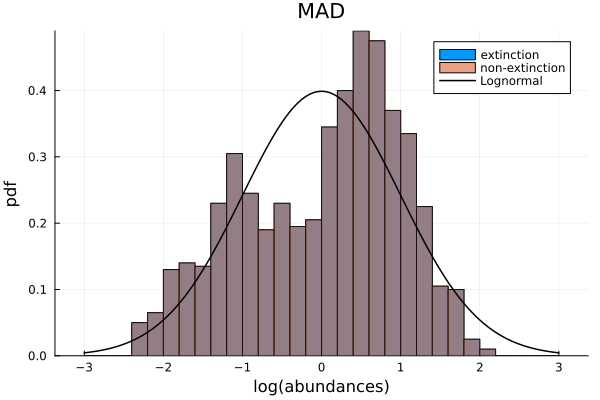

"/home/luca/code/lawsdiv/Images/extinction_hist1.png"

In [41]:
y = y[1:end, :]
mask = .!map(col -> count(iszero, col) == size(y,1), eachcol(y))
y = y[:,mask]

fig = plot(xlabel="log(abundances)", ylabel="pdf", title="MAD")

# Extinction case
log_data = [log(mean(x)) for x in eachcol(y)]
centered_log_data = (log_data .- mean(log_data)) ./ (std(log_data))
println(count(isnan.(y)))

bmin = floor(minimum(centered_log_data))
bmax = ceil(maximum(centered_log_data))
Δb = 0.2
fh = FHist.Hist1D(centered_log_data, binedges=bmin:Δb:bmax) |> normalize

plot!(fig, fh, label="extinction")

# Non-extinction case
log_data = [log(mean(x[x .> 0.0]) * length(x[x .> 0.0]) / length(x)) for x in eachcol(y)]
# log_data = [log(mean(x[x .> 0.0])) for x in eachcol(y)]
centered_log_data = (log_data .- mean(log_data)) ./ (std(log_data))

bmin = floor(minimum(centered_log_data))
bmax = ceil(maximum(centered_log_data))
Δb = 0.2
fh = FHist.Hist1D(centered_log_data, binedges=bmin:Δb:bmax) |> normalize

plot!(fig, fh, label="non-extinction", alpha=0.65)

xarr = -3.0:0.05:3.0
lognorm = [exp(-x^2 / 2) / (sqrt(2 * π)) for x in xarr] # Standard Gaussian centered at 0
plot!(fig, xarr, lognorm, color=:black, label="Lognormal", lw=1.5)
display(fig)
savefig("./Images/extinction_hist1.png")

In [23]:
# fig = plot(xlabel="log(abundances)", ylabel="pdf", title="MAD", yscale=:log10, legend=:topleft)

# xarr = -3.0:0.05:3.0
# lognorm = [10^(-x^2) for x in xarr] # Standard Gaussian centered at 0
# plot!(fig, xarr, lognorm, color=:black, label="Lognormal", lw=1.5)

# # Extinction case
# log_data = [log(mean(x)) for x in eachcol(y)]
# bmin = floor(minimum(log_data))
# bmax = ceil(maximum(log_data))
# fh = FHist.Hist1D(log_data, binedges=bmin:Δb:bmax)

# # Renormalize the histogram and shift the centers
# μ, σ = mean(fh), std(fh)
# centers = bincenters(fh)
# centers .-= μ
# centers ./= sqrt(2 * σ^2)
# norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
# yy = [10^log(norm_counts[norm_counts.>0.0][i] * sqrt(2 * π * σ^2)) for i in eachindex(norm_counts[norm_counts.>0.0])]
# centers = centers[norm_counts.>0.0]
# scatter!(fig, centers, yy, label="extinction")

# # Non-extinction case
# log_data = [log(mean(x[x .> 0.0])) for x in eachcol(y)]
# bmin = floor(minimum(log_data))
# bmax = ceil(maximum(log_data))
# fh = FHist.Hist1D(log_data, binedges=bmin:Δb:bmax)

# # Renormalize the histogram and shift the centers
# μ, σ = mean(fh), std(fh)
# centers = bincenters(fh)
# centers .-= μ
# centers ./= sqrt(2 * σ^2)
# norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
# yy = [10^log(norm_counts[norm_counts.>0.0][i] * sqrt(2 * π * σ^2)) for i in eachindex(norm_counts[norm_counts.>0.0])]
# centers = centers[norm_counts.>0.0]
# scatter!(fig, centers, yy, label="non-extinction")

# display(fig)
# # savefig("./Images/extinction_hist2.png") 

In [24]:
# dead_species = y[end, :] .< 1e-5
# dead_traj = y[:, dead_species]
# fig = plot(xlabel="time step", ylabel="abundance", legend=nothing, yscale=:log10, size=(600, 250), margin=5mm)
# for i in 1:4
#     plot!(fig, y[:,i], label="traj $i")
#     plot!(fig, dead_traj[:,i], label="traj $(i + 4)")
# end

# display(fig)
# savefig("./Images/small_traj.png")